## Notebook on Argon (Nosé-Hoover)

Notebook prepared by F. Troni - Course of Statistical Mechanics (Kigali, 03/2025)

In this notebook we study how to set up a real simulation of an argon molecule. We study how the temperature and energy change. We analyze and understand how to use a Nosé-Hoover thermostat.

**Theory:** section 3.8.3, 4.8.3

In [181]:
import numpy as np
import matplotlib.pyplot as plt

### Set up of the systems and useful functions

In [182]:
# Constants for Argon (Lennard-Jones parameters in reduced units)
sigma = 3.4         # Å
epsilon = 0.0103    # eV
mass = 39.948       # amu
L = 10.0            # Box size in Å
dt = 0.25           # Time step in fs
n_steps = 10000     # Number of time steps
Np = 10             # Number of particles
T_target = 300.0    # Target temperature in K
kB = 3.1668 * 1e-6  # Eh/K - Boltzmann constant
#kB = 8.617333e-5   # eV/K
stride = 5

If  Q  is too large:

	•	The thermostat reacts too slowly. 
	•	Temperature oscillations are large and take a long time to stabilize.
	•	The system may behave as if it’s almost in the NVE ensemble (constant energy) because the thermostat is too weak.

If  Q  is too small:

	•	The thermostat reacts too aggressively.
	•	Temperature fluctuates wildly or becomes unstable.
	•	The system might behave unphysically.

Good rule of thumb: $Q = \tau_T k_B T_\text{target} \approx 10$, where $\tau_T$ is a characteristic time scale for temperature fluctuations.

In [183]:
Q = 10.0           # Thermostat mass
thermostat = True   # Enable/Disable Nosé-Hoover

In [184]:
# convert mass from amu to au
amu_to_kg = 1.66054 * 1e-27 
m_e = 9.1093837 * 1e-31 #kg
conv_mass = amu_to_kg / m_e
mass *= conv_mass

# convert side of the box from Å to au
a0 = 0.529177210903 #Angstrom 
L /= a0

# convert time from fs to au
t_au = 2.4188843265857 * 1e-2 #fs = 1 a.u. of time 
dt /= t_au

print('Converted quantities:')
print(f'mass = {mass} a.u., L = {L} a.u., dt = {dt} a.u.')

Converted quantities:
mass = 72820.79019242541 a.u., L = 18.897261246257703 a.u., dt = 10.335343333795528 a.u.


In [185]:
### PLOTTING FUNCTIONS ###

def plot_temperature(steps_plot, temperatures):
    time = np.array(steps_plot) * dt
    plt.figure(figsize=(10, 6))
    plt.plot(time / 1000 * t_au, temperatures, label="Temperature", linestyle='-', linewidth=0.8)
    plt.axhline(y=T_target, color='r', linestyle='--', label="Target Temperature")
    # plt.ylim([T_target - 50, T_target + 50])
    plt.xlabel("Time [ps]", fontsize=12)
    plt.ylabel("Temperature [K]", fontsize=12)
    plt.legend(fontsize=10, loc='upper left')
    plt.show()

def plot_xi(steps_plot, xi):
    time = np.array(steps_plot) * dt
    plt.figure(figsize=(10, 6))
    plt.plot(time / 1000 * t_au, xi, label="Temperature", linestyle='-', linewidth=0.8)
    plt.axhline(y=T_target, color='r', linestyle='--', label="Target Temperature")
    # plt.ylim([T_target - 50, T_target + 50])
    plt.xlabel("Time [ps]", fontsize=12)
    plt.ylabel("xi ", fontsize=12)
    plt.legend(fontsize=10, loc='upper left')
    plt.show()


def plot_energy(steps_plot, energies):
    time = np.array(steps_plot) * dt
    plt.figure(figsize=(10, 6))
    plt.plot(time / 1000 * t_au, energies, linestyle='-', linewidth=0.8, color='r')
    # plt.ylim([T_target - 50, T_target + 50])
    plt.xlabel("Time [ps]", fontsize=12)
    plt.ylabel("Total Energy [a.u.]", fontsize=12)
    # plt.legend(fontsize=10, loc='upper left')
    plt.show()

##########################################################################################
### INITIALIZATION FUNCTIONS ###

# Places each atom in a simple cubic lattice within the box.
def assign_positions():
    n = int(np.ceil(Np ** (1/3)))  # Number of atoms per dimension
    x, y, z = np.meshgrid(np.arange(n), np.arange(n), np.arange(n), indexing='ij')  # 3D grid
    positions = np.vstack((x.ravel(), y.ravel(), z.ravel())).T * sigma  # Reshape and scale

    return positions[:Np]  # Select only Np atoms

# Assign velocities extracting them from Maxwell-Boltzmann distribution
def assign_velocities():
    velocities = []
    std = np.sqrt(kB * T_target / mass)   
    
    for p in range(Np):
        velocities.append([np.random.normal(loc = 0.0, scale = std) for i in range(3)])
    
    return np.array(velocities)

##########################################################################################
### COMPUTE QUANTITIES AND APPLY PBC ###

# Apply periodic boundary conditions.
def apply_pbc(positions, L):
    return positions % L

# Compute Lennard-Jones force for a pair of atoms.
def compute_lj_force(rij):
    r2 = np.dot(rij, rij)
    if r2 == 0:
        return np.zeros(3)
    r6 = (sigma**2 / r2)**3
    r12 = r6**2
    force_mag = 24 * epsilon * (2 * r12 - r6) / r2
    return force_mag * rij / np.sqrt(r2)

def compute_forces(positions, L):
    """Compute forces on all particles."""
    forces = np.zeros_like(positions)
    for i in range(Np):
        for j in range(i + 1, Np):
            rij = positions[i] - positions[j]
            rij -= np.rint(rij / L) * L  # Minimum image convention
            force = compute_lj_force(rij)
            forces[i] += force
            forces[j] -= force  # Newton's third law
    return forces

# Compute instantaneous temperature.
def compute_temperature(velocities):
    kinetic_energy = 0.5 * mass * np.sum(velocities**2)
    return (2 * kinetic_energy) / (3 * Np * kB)

# Compute Lennard-Jones potential energy for a pair of atoms.
def compute_lj_potential(rij):

    r2 = np.dot(rij, rij)
    if r2 == 0:
        return 0.0
    r6 = (sigma**2 / r2)**3
    r12 = r6**2
    return 4 * epsilon * (r12 - r6)

# Compute the total energy of the system
def compute_energy(positions, velocities):
    kinetic_energy = 0.5 * mass * np.sum(velocities**2)
    potential_energy = 0.0
    for i in range(Np):
        for j in range(i + 1, Np):
            rij = positions[i] - positions[j]
            rij -= np.rint(rij / L) * L  # Minimum image convention
            potential_energy += compute_lj_potential(rij)
    return kinetic_energy + potential_energy

##########################################################################################
### ALGORITHMS ###

# Applying the Nosé-Hoover thermostat
def nose_hoover_thermostat(positions, velocities, forces, xi, eta):
    # Update positions
    positions += velocities * dt + 0.5 * (forces / mass - xi * velocities) * dt**2
    positions = apply_pbc(positions, L)
    
    # Update velocity (half step)
    velocities += 0.5 * (forces / mass - xi * velocities) * dt
    
    # Update forces
    forces = compute_forces(positions, L)
    
    # Compute kinetic energy
    kinetic_energy = 0.5 * mass * np.sum(velocities**2)
    
    # Update thermostat variables
    xi += 0.5 * (dt / Q) * (kinetic_energy - 0.5 * (3 * Np + 1) * kB * T_target)
    kinetic_energy = 0.5 * mass * np.sum(velocities**2)  # Recompute after update
    xi += 0.5 * (dt / Q) * (kinetic_energy - 0.5 * (3 * Np + 1) * kB * T_target)
    eta += xi * dt  # Accumulate thermostat variable
    
    # Update velocity (another half step)
    velocities = (velocities + 0.5 * (forces / mass) * dt) / (1 + 0.5 * xi * dt)
    
    return positions, velocities, forces, xi, eta

# Simulation function that applies velocity Verlet (+ Nosé-Hoover if thermostat == True)
def velocity_verlet(positions, velocities, L, dt, thermostat, stride):
    # Store steps of the plot
    steps_plot = []
    
    # Store temperature per step
    temperatures = []
    
    # Store energy per step
    tot_energies = []

    if thermostat:
        xi = 0
        eta = 0

    forces = compute_forces(positions, L)
    for step in range(n_steps):
        if thermostat:
            positions, velocities, forces, xi, eta = nose_hoover_thermostat(positions, velocities, forces, xi, eta)
        else:
            # Update positions
            positions += velocities * dt + 0.5 * forces * dt**2
            positions = apply_pbc(positions, L)
            
            # Compute new forces
            new_forces = compute_forces(positions, L)
            
            # Update velocities
            velocities += 0.5 * (forces + new_forces) * dt
            forces = new_forces
        
        if step % stride == 0:
            steps_plot.append(step)

            # Compute and store temperature
            temperature = compute_temperature(velocities)
            temperatures.append(temperature)
            
            # Compute and store energy
            energy = compute_energy(positions, velocities)
            tot_energies.append(energy)
        
        # Print or save positions for analysis
        if step % 100 == 0:
            print(f"Step {step}: Energy = {energy:.2f}, Temperature = {temperature:.2f} K")
        
    return steps_plot, tot_energies, temperatures

#### The potential

We are using the Lennard-Jones potential to simulate the repulsion between atoms to avoid overlap between particles

$V_{\text{LJ}}(r) = 4\epsilon \left[ \left( \frac{\sigma}{r} \right)^{12} - \left( \frac{\sigma}{r} \right)^{6} \right]$

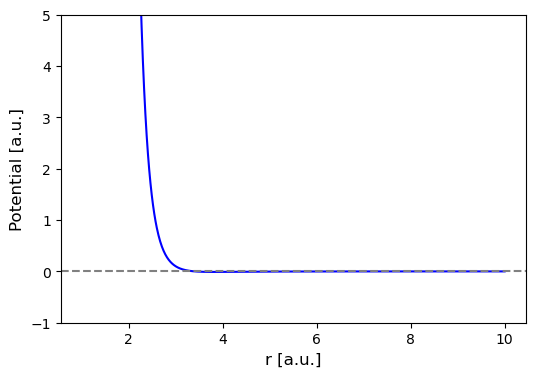

In [192]:
r = np.linspace(1, 10, 1000)
potential = [compute_lj_potential(r_ij) for r_ij in r]

plt.figure(figsize=(6, 4))
plt.plot(r, potential, linestyle='-', color='b')
plt.axhline(0, linestyle='--', color='grey')
plt.xlabel("r [a.u.]", fontsize=12)
plt.ylabel("Potential [a.u.]", fontsize=12)
plt.ylim([-1, 5])
# plt.legend(fontsize=10, loc='upper left')
plt.show()

### The simulation

Before starting the simulation, we need to initialize the positions and velocities of the particles

In [187]:
# Initialize positions
positions = assign_positions()

# Initializa velocities with MB distribution
velocities = assign_velocities()

# Thermostat variables
xi = 0.0
eta = 0.0

In [188]:
# Run the simulation
steps_plot, tot_energies, temperatures = velocity_verlet(positions, velocities, L, dt, thermostat, stride)

Step 0: Energy = -0.04, Temperature = 242.64 K
Step 100: Energy = -0.12, Temperature = 269.46 K
Step 200: Energy = -0.15, Temperature = 284.28 K
Step 300: Energy = -0.15, Temperature = 294.26 K
Step 400: Energy = -0.13, Temperature = 304.96 K
Step 500: Energy = -0.11, Temperature = 317.40 K
Step 600: Energy = -0.10, Temperature = 330.98 K
Step 700: Energy = -0.09, Temperature = 344.59 K
Step 800: Energy = -0.07, Temperature = 358.36 K
Step 900: Energy = -0.07, Temperature = 368.14 K
Step 1000: Energy = -0.07, Temperature = 375.17 K
Step 1100: Energy = -0.05, Temperature = 385.04 K
Step 1200: Energy = -0.05, Temperature = 382.75 K
Step 1300: Energy = -0.05, Temperature = 381.72 K
Step 1400: Energy = -0.04, Temperature = 377.51 K
Step 1500: Energy = -0.04, Temperature = 368.77 K
Step 1600: Energy = -0.04, Temperature = 358.80 K
Step 1700: Energy = -0.04, Temperature = 347.49 K
Step 1800: Energy = -0.04, Temperature = 335.15 K
Step 1900: Energy = -0.04, Temperature = 322.13 K
Step 2000: E

### Analysis of the temperature and energy of the system

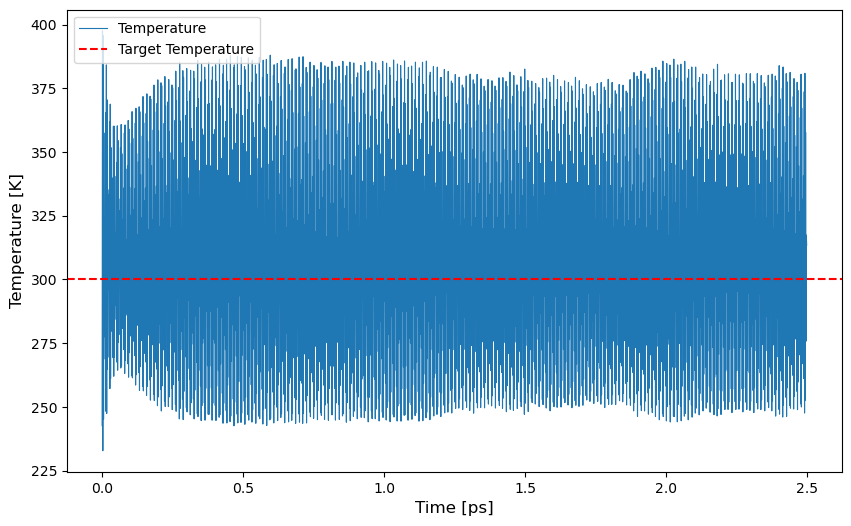

In [189]:
# Plot the temperature evolution
plot_temperature(steps_plot, temperatures)

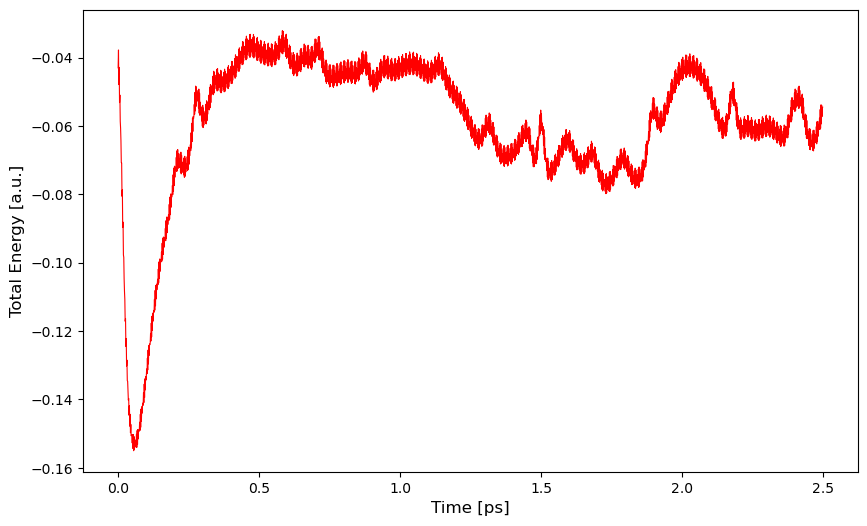

In [190]:
# Plot of the total energy during the simulation
plot_energy(steps_plot, tot_energies)